## Import necessary libraries and modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os 
import seaborn as sns
import statistics

np.random.seed(27983420)

In [2]:
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

I want to have interactive plots and visualizations for my data, so I'm going to use HoloViews.

In [3]:
# put all the HoloViews stuff here
# tbh might not need this? we'll see. 

### Load the cleaned dataset

In [4]:
# load in dataset
mutants = pd.read_csv('../data/interim/k8_clean_data.csv', header=None, low_memory=False)

In [5]:
mutants.head()

,0,1,2,3,4,5,6,7,8,9,...,5400,5401,5402,5403,5404,5405,5406,5407,5408,5409
0,-0.161,-0.014,0.002,-0.036,-0.033,-0.093,0.025,0.005,0.000,-0.015,...,0.013,0.021,0.020,0.016,-0.011,0.003,0.010,-0.007,a119e_l125p,inactive
1,-0.158,-0.002,-0.012,-0.025,-0.012,-0.106,0.013,0.005,0.000,-0.002,...,-0.008,0.007,0.015,-0.008,-0.011,-0.004,0.013,0.005,a119e_r283k_a353v,inactive
2,-0.169,-0.025,-0.010,-0.041,-0.045,-0.069,0.038,0.014,0.008,-0.014,...,0.010,0.025,0.025,0.021,-0.012,0.006,0.016,-0.018,c135y,inactive
3,-0.183,-0.051,-0.023,-0.077,-0.092,-0.015,0.071,0.027,0.020,-0.019,...,0.012,0.050,0.038,0.051,-0.015,0.017,0.027,-0.049,c135y_e285m,inactive
4,-0.154,0.005,-0.011,-0.013,-0.002,-0.115,0.005,0.002,-0.003,0.002,...,0.012,0.009,0.003,-0.001,0.002,-0.006,0.009,0.013,c135y_e285v,inactive


In [6]:
# pop out the column of mutants with the nametags, for safekeeping

nametags = mutants.pop(5408).astype(str)
print(nametags)

# since we'll be manipulating the columns of the mutants dataframe, we don't need to keep track of the labels associated with each row

0              a119e_l125p
1        a119e_r283k_a353v
2                    c135y
3              c135y_e285m
4              c135y_e285v
               ...        
16586    y220c_t230c_n239y
16587    y220c_y234f_n239l
16588                y234c
16589          y234c_a119e
16590          y234f_n239l
Name: 5408, Length: 16591, dtype: object


In [7]:
# new mutants dataframe
mutants.head()

,0,1,2,3,4,5,6,7,8,9,...,5399,5400,5401,5402,5403,5404,5405,5406,5407,5409
0,-0.161,-0.014,0.002,-0.036,-0.033,-0.093,0.025,0.005,0.000,-0.015,...,0.006,0.013,0.021,0.020,0.016,-0.011,0.003,0.010,-0.007,inactive
1,-0.158,-0.002,-0.012,-0.025,-0.012,-0.106,0.013,0.005,0.000,-0.002,...,0.002,-0.008,0.007,0.015,-0.008,-0.011,-0.004,0.013,0.005,inactive
2,-0.169,-0.025,-0.010,-0.041,-0.045,-0.069,0.038,0.014,0.008,-0.014,...,0.019,0.010,0.025,0.025,0.021,-0.012,0.006,0.016,-0.018,inactive
3,-0.183,-0.051,-0.023,-0.077,-0.092,-0.015,0.071,0.027,0.020,-0.019,...,0.051,0.012,0.050,0.038,0.051,-0.015,0.017,0.027,-0.049,inactive
4,-0.154,0.005,-0.011,-0.013,-0.002,-0.115,0.005,0.002,-0.003,0.002,...,-0.011,0.012,0.009,0.003,-0.001,0.002,-0.006,0.009,0.013,inactive


## Dimensionality Reduction

Due to the highly dimensional nature of this dataset (5408 features!!) and the resulting complexity, knowing where to start is difficult. More common visualization techniques for lower dimensional data are too computationally expensive and time-consuming to be useful at this point. 

Some first steps to reduce dimensionality would be:

1) Search for features with no variance and drop these features, since they do not provide any information for our classification problem.

2) Look for multicollinearity in the features! Identify features that are highly linearly correlated with each other or features that have a high PMI (point-wise mutual information) score. These features are redundant, as having many features with a high PMI score or high linear correlation do not provide additional information. 

Since I am not sure yet whether the features have linear or nonlinear (geometric?) relationships, I will be using both the linear correlation and the PMI scores (mutual information captures non-linear relationships) for the dimensionality reduction and comparing the results of both methods.

### Find Features with No Variance or Low Variance

Using the pandas describe() method, I will be looking for numerical features that have a standard deviation = 0 and min and max values that are equal to each other. These features will be dropped. 

I will also make a note of features that have very low variance, especially compared to the rest of the features, and investigate the relevance of those features further.

In [8]:
desc = mutants.describe()
desc.head()

,0,1,2,3,4,5,6,7,8,9,...,5398,5399,5400,5401,5402,5403,5404,5405,5406,5407
count,16591.000000,16591.000000,16591.000000,16591.000000,16591.000000,16591.000000,16591.000000,16591.000000,16591.000000,16591.000000,...,16591.000000,16591.000000,16591.000000,16591.000000,16591.000000,16591.000000,16591.000000,16591.000000,16591.000000,16591.000000
mean,-0.201763,-0.004898,-0.011593,-0.024726,-0.019615,-0.077004,0.222236,0.011294,0.009716,0.009895,...,-0.009736,0.002827,0.004689,0.011400,0.018242,0.001767,-0.011238,0.001415,0.011424,-0.000615
std,0.415089,0.362149,0.244942,0.256497,0.195207,0.539291,1.991421,0.127339,0.210814,0.339393,...,0.011281,0.020840,0.018827,0.024245,0.013061,0.033117,0.009405,0.015348,0.009534,0.022943
min,-6.085000,-7.409000,-4.410000,-3.419000,-3.270000,-2.241000,-0.512000,-0.685000,-0.684000,-0.534000,...,-0.392000,-0.167000,-0.233000,-0.531000,-0.075000,-0.204000,-0.522000,-0.042000,-0.112000,-0.194000
25%,-0.169000,-0.024000,-0.014000,-0.040000,-0.043000,-0.113000,0.006000,0.002000,-0.003000,-0.017000,...,-0.014000,-0.008000,-0.007000,-0.002000,0.011000,-0.019000,-0.012000,-0.006000,0.009000,-0.014000


Before I start removing features, I want to explore the standard deviations of these features. What are the ranges of the standard deviations? What is the smallest standard deviation? What is the largest standard deviation? What is the mean and median standard deviation? Are any of the standard deviations equal to 0? 

Doing this will give me a better idea of which features have relatively low variance and won't be useful.

In [9]:
desc.index

Index(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], dtype='object')

In [10]:
descT = desc.T
descT.head()

,count,mean,std,min,25%,50%,75%,max
0,16591.0,-0.201763,0.415089,-6.085,-0.169,-0.162,-0.154,2.323
1,16591.0,-0.004898,0.362149,-7.409,-0.024,-0.010,0.005,4.552
2,16591.0,-0.011593,0.244942,-4.410,-0.014,-0.010,-0.003,2.872
3,16591.0,-0.024726,0.256497,-3.419,-0.040,-0.034,-0.012,17.831
4,16591.0,-0.019615,0.195207,-3.270,-0.043,-0.023,-0.001,4.571


The minimum standard deviation for the original features is 0.006618814893812356
The maximum standard deviation for the original features is 77.3480716547277


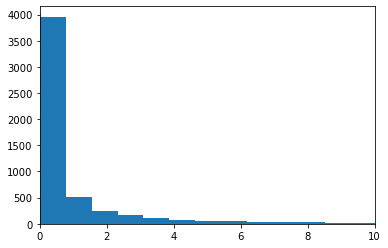

In [21]:
std_min = descT['std'].min()
print("The minimum standard deviation for the original features is {}".format(std_min))

std_max = descT['std'].max()
print("The maximum standard deviation for the original features is {}".format(std_max))

# plot a histogram of the descT['std'] values so that we can see the distribution
#sns.histplot(data=descT, x="std")
_ = plt.hist(x=descT['std'], bins=100)
_ = plt.xlim([0, 10])

The standard deviations have a very large range, and are right skewed. Since the minimum is 0.0066, there aren't any features with a standard deviation of 0, but there are features with standard deviations that are very, very close to 0.

In [12]:
descT.describe() # focus on the 'std' column! 

,count,mean,std,min,25%,50%,75%,max
count,5408.0,5408.000000,5408.000000,5408.000000,5408.000000,5408.000000,5408.000000,5408.000000
mean,16591.0,0.163703,1.188337,-10.564887,-0.275089,0.087606,0.564449,18.131332
std,0.0,3.482811,3.029671,16.820849,3.499720,3.806637,3.824114,31.861964
min,16591.0,-87.251644,0.006619,-255.926167,-91.454000,-86.965000,-82.645000,0.000000
25%,16591.0,-0.030156,0.148570,-11.160500,-0.061000,-0.025000,-0.004000,1.606750
50%,16591.0,0.013918,0.297502,-4.737000,-0.011000,0.011000,0.033000,4.345500
75%,16591.0,0.148052,0.892012,-2.339750,0.023000,0.135000,0.282000,19.545750
max,16591.0,57.955999,77.348072,-0.032000,47.499500,62.450000,71.864000,281.988000


Based on this information about the standard deviations, most of the features have a low variance, or a standard deviation less than 1. Thus, I'll set my cutoff threshold for the "low" standard deviations at 1.0. This should get rid of more than 75% of the features. 

In [22]:
logical = descT['std'] < 1.0
low_var_cols = list(descT.index[logical]) # contains the column numbers of the features with low variances

In [23]:
len(low_var_cols)

4149

In [24]:
mutants.columns

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            5399, 5400, 5401, 5402, 5403, 5404, 5405, 5406, 5407, 5409],
           dtype='int64', length=5409)

In [25]:
hv_mutants = mutants.drop(low_var_cols, axis=1)
hv_mutants.head()

,6,10,11,25,106,288,293,294,300,301,...,4813,4814,4815,4816,4817,4820,4821,4822,4825,5409
0,0.025,-0.030,-0.050,-0.031,-0.144053,-4.485,-4.222,-4.109,-0.033,-3.665,...,0.033067,-2.246,-1.037,24.298,48.519,1.971567,0.120300,0.582294,-0.381114,inactive
1,0.013,-0.007,-0.010,-0.019,-0.172632,-4.489,-4.238,-4.111,-0.057,-3.725,...,-1.028600,-1.808,3.705,21.268,62.454,1.771478,-0.112233,0.537647,0.615029,inactive
2,0.038,-0.032,-0.043,-0.036,-0.158158,-4.485,-4.224,-4.107,-0.031,-3.643,...,-0.503633,-2.324,-0.533,24.274,49.118,1.876060,0.648200,0.396000,-0.350229,inactive
3,0.071,-0.044,-0.097,-0.058,-0.038211,-4.484,-4.219,-4.106,-0.145,-3.998,...,0.218600,-2.305,-2.126,16.750,56.411,2.753896,0.537033,0.455118,-3.266400,inactive
4,0.005,0.006,-0.002,-0.011,-0.178263,-4.490,-4.239,-4.110,-0.060,-3.741,...,-1.339100,-2.378,4.155,20.821,61.475,0.856254,-2.289233,0.309824,1.177314,inactive


Using this method, I was able to narrow down my dataset to 1260 features from 5408 features! Now I can filter out even more important features using the following methods.

One important note is that by setting the low variance threshold at 1.0, all of the features above feature 4825 have been dropped - in other words, all of the 3D (distance-based) features had a standard deviation of less than 1.0, and were dropped from the dataframe. Henceforth, all of the further analysis will be done on the remaining 2D features. Investigating *why* the 3D features all had such low variances is important, and requires a sanity check.

### Using Linear Correlation to Reduce Dimensionality

My strategy for dimensionality reduction using linear correlation, excluding non-numerical features, is as follows:

1) Start by looking at only the 2D, or electrostatic and surface-based features. This will be all features (or columns) up to feature 4827, in the dataset.

2) Calculate the linear correlation of the first two features with each other. This is a measure of the **redundancy** of the two features.
    
    (a) If this value is higher than the chosen threshold value, then that tells me that the two features are collinear and are redundant. Now, decide which of the two features to drop by proceeding to step #3.
    
    (b) If this value is lower than the chosen threshold value, then that tells me that the two features are not collinear and both features will be retained in the dataset. Proceed to step #4.

3) Take the two features from step #2 and calculate their correlation with the rest of the features. This will give a [2 x 1259] correlation matrix. Calculate the median of the values of each row, giving two numbers which summarize how highly correlated the two features are with the rest of the 2D features, aka **the relevancy of that feature to the rest of the dataset**. *The average is susceptible to bias from outliers, so the median is a better summary statistic* 
    
    (a) If one of the two values is much larger than the other, then drop the feature with the larger value since that feature has more repeated information over the whole dataset than the other feature. If the two values are the same, then drop the first feature.

4) Move on to the next two features and repeat the process for all of the 2D features. 

5) After subsetting the 2D features in this way, repeat the process with the 3D (distance-based) features and combine the data. 

6) Investigate the relationships of the selected features with the target variable (inactive or active). 

In [30]:
hv_list = list(hv_mutants.columns) # check the remaining column names
hv_len = len(hv_list)
hv_corr = hv_mutants.corr()

In [31]:
hv_corr = hv_corr.abs() # make all the elements positive

I made all the elements in the correlation matrix positive, because I only want to see if features are highly correlated at this point, not whether the features are positively correlated or negatively correlated.

In [35]:
upper_tri = hv_corr.where(np.triu(np.ones(hv_corr.shape), k=1).astype(np.bool))

In [36]:
high_corr_cols = [col for col in upper_tri.columns if any(upper_tri[col] > 0.90)]

In [38]:
len(high_corr_cols)

220

In [37]:
hv_mutants = hv_mutants.drop(high_corr_cols, axis=1) # drop the highly correlated features
hv_mutants.head()

KeyError: '[  11  293  294  302  305  721  724  731  732  736  737  738  739  743\n  744  745  747  873  875  881  882  883  885 1445 1447 1679 1680 1681\n 1682 1683 1684 1685 1686 1687 1688 1690 1691 1692 1693 1694 1702 1703\n 1709 1710 1711 1712 1719 1720 1721 1725 1726 2056 2403 2404 2405 2406\n 2504 2521 2611 2663 2705 2707 2712 2713 2715 2716 2717 2718 2797 2800\n 2819 2834 2846 2875 2948 3035 3112 3116 3117 3133 3138 3151 3157 3159\n 3162 3287 3293 3294 3297 3298 3382 3450 3478 3507 3513 3525 3558 3559\n 3561 3578 3605 3710 3748 3750 3756 3775 3776 3777 3779 3782 3783 3784\n 3785 3790 3793 3796 3797 3801 3804 3807 3808 3811 3815 3816 3817 3818\n 3825 3826 3828 3829 3858 3860 3863 3865 3866 3875 3901 3902 3918 3921\n 3931 3932 3937 3938 3940 3948 3952 3959 3964 3966 3990 4088 4089 4091\n 4092 4093 4096 4097 4098 4100 4101 4102 4110 4111 4112 4116 4120 4121\n 4123 4124 4125 4129 4130 4131 4133 4135 4138 4139 4216 4224 4228 4229\n 4230 4232 4238 4239 4240 4241 4248 4249 4250 4266 4278 4323 4421 4422\n 4466 4518 4595 4696 4738 4739 4740 4741 4746 4747 4748 4749 4751 4752\n 4753 4754 4755 4758 4763 4768 4779 4792 4807 4817] not found in axis'

In [26]:
# filtering 2D features from hv_mutants dataframe: Attempt 1
# concern: might not be evaluating all possible pairwise combinations

hv_list = list(hv_mutants.columns) # check the remaining column names
hv_len = len(hv_list)

for i in range(0, hv_len):
    corr = hv_mutants[hv_list[i]].corr(hv_mutants[hv_list[i+1]])
    
    if corr < 0.90:
        continue
    elif corr >= 0.90:
        corr_1 = np.matrix(hv_mutants.corr(hv_mutants[hv_list[i]]))
        corr_2 = np.matrix(hv_mutants.corr(hv_mutants[hv_list[i+1]]))
        
        if np.mean(corr_1) >= np.mean(corr_2):
            hv_mutants.drop(hv_mutants.columns[[i]], axis=1, inplace=True)
        else:
            hv_mutants.drop(hv_mutants.columns[[i+1]], axis=1, inplace=True)


Int64Index([   6,   10,   11,   25,  106,  288,  293,  294,  300,  301,
            ...
            4813, 4814, 4815, 4816, 4817, 4820, 4821, 4822, 4825, 5409],
           dtype='int64', length=1260)

### Using Mutual Information to Reduce Dimensionality

My strategy for dimensionality reduction using mutual information is as follows:

1) Determine a threshold value for the PMI score. 

2) Take the first two features (columns) and calculate the PMI score between them. 

    (a) If the PMI score is large (above threshold value), then that means that those two features are highly dependent. In this case, keep the feature with the largest information gain and store in a dataframe. The other feature will be removed and stored in a separate dataframe. 
    
    (b) If the PMI score is low (below threshold value), then those two features are weakly correlated and both features may be retained. 
    
    (c) If the PMI score is 0, then the two features are statistically independent and both features may be retained.


3) Repeat the process with the next set of two features until all the 2D features have been tested. 

4) Continue the process with the 3D features.

Afterwards, I will investigate the relationships of the remaining features with the target variable.